# Mathematical background

## Fitting single harmonics [1]

We fit single harmonics to the anomalous data (data values minus the mean) using a Fourier transform to find the coefficients 
$$ A_k = \frac{2}{n}\sum_{i=1}^{n}y_n\cos\left(\frac{2\pi i k}{n}\right)$$
and
$$ B_k = \frac{2}{n}\sum_{i=1}^{n}y_n\sin\left(\frac{2\pi i k}{n}\right)$$
of
$$ y_i - \overline{y} = A_k \cos\left(\frac{2\pi i k}{n}\right) + B_k \sin\left(\frac{2\pi i k}{n}\right) $$

Here $k$ is the harmonic being fitted to the anomaly of some data.
To carry this out we write a function `fourier_coeffs` to which calculates $A_{k}$ and $B_{k}$ as well as functions to compute the sine and cosine sums.

This will be used for both water and air temperature to fit a few discrete harmonics.

In [46]:
function fourier_coeffs(y, k)
    n = length(y)
    i = 1:n
    Ak = (2 / n) * sum(y .* cos.((2 * pi * i * k) / n))
    Bk = (2 / n) * sum(y .* sin.((2 * pi * i * k) / n))
    return [Ak, Bk]
end

fourier_coeffs (generic function with 1 method)

In [47]:
@. cosfunc(i, k, N) = sum( cos( (2*pi*i*k) / N) )
@. sinfunc(i, k, N) = sum( sin( (2*pi*i*k) / N) )

sinfunc (generic function with 1 method)

## Spectral density [1]

We can look at the spectral density of the sea level by using a power spectrum (or periodogram) to see how the processes at different frequencies contribute to a time series.
This arises by considering the Fourier coefficients $A_{k}$ and $B_{k}$ above as functions of frequency - that is how 
$$
C_{k}^{2} = A_{k}^{2} + B_{k}^{2}
$$
varies as the frequency $f_{k}$ varies.

In doing so we encounter the *Nyquist frequency* and aliasing errors.
The *Nyquist frequency* executes $\frac{n}{2}$ cycles over the full data and depends on the temporal resolution of the data.
This limits the information available from spectral analysis because there are only so many allowable frequencies for a data set that are determined by the number of cycles in the data.
Hence the spectra are only computed up to $m = \frac{n}{2}$ determined by the Nyquist frequency. 

This can be computed by using the function `C_k` below which computes $C_{k}$ from the function `fourier_coeffs`.
The *Nyquist frequency* determines the value $m = \frac{n}{2}$ so for the periodogram we compute the $C_{k}$ corresponding to the $\frac{n}{2}-1$ spectra then determine the $A_{k}$ and $B_{k}$ coefficients for $\frac{n}{2}$ by
$$
A_{n/2} = 
\begin{cases}
    \frac{1}{n} \sum_{i}^{n}y_{i}\cos(\pi i) & n \text{ even} \\
    0 & n \text{ odd} 
\end{cases}
$$
and 
$$
B_{n/2} = 
\begin{cases}
    0 & n \text{ even} \\
    0 & n \text{ odd}.
\end{cases}
$$

In [48]:
function C_k(y, k)
    F_coeffs = fourier_coeffs(y, k)
    return F_coeffs[1]^2 + F_coeffs[2]^2
end

C_k (generic function with 1 method)

The above function will compute the appropriate Fourier coefficients however it is not very well optimised and as this data set is reasonably large we can use the `FFTW.jl` package instead.
This uses the much more efficient fast Fourier transform algorithm to compute the complex Fourier coefficients for the data for all $k$.
Depending on the *Nyquist frequency* we then take the required coefficients from this set of complex Fourier coefficients (the real of the complex Fourier coefficient is $A_{k}$ and the imagainary part is $B_{k}$).

The periodograms looked at will be Fourier coefficient $C_{k}$ against freqeuncy $f_{k} = \frac{k}{n}$.
This will give an indication of which frequencies are important which can be related to a period by
$$
\tau_{k} = \frac{1}{f_{k}}.
$$

Finding the frequencies which contribute most in the periodogram allows a reconstruction to be made by superimposing a subset of the most important harmonics to capture the behaviour of the time series.

# Data

I have chosen to look at the data collected from Port Vila (on the island of Efate, Vanuatu) in 2017.
The data and metadata were downloaded from [here](http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml) with further metadata (e.g. units of measurements, errors etc.) found [here](http://www.bom.gov.au/oceanography/projects/spslcmp/data/data.shtml).

The data contains hourly observations recorded between midnight (Universal Time Cooridnated time UTC) 1st January 2017 and 23:00 (UTC) 31st December 2017 of:

- sea level (metres above tide gauge = 0)
- water temperature (degrees celsius)
- air temperature (degrees celsius)
- barometric pressure (hectopascals)
- residuals (measure of discrepancy between observed sea level and predicted sea level, metres)
- adjusted residuals (measure of discrepancy between observed sea level and predicted sea level adjusted for static barometric pressure effect, metres)
- wind direction (degrees true)
- wind gust (metres per second)
- wind speed (metres per second)

from latitude 17° 45' 41" S and longtitude 168° 17' 35" E.

The total number of observations recorded is 8760.

## Source of data

The data is provided by the Australian Bureau of Meterology and comes from the *Pacific Sea Level and Geodetic Monitoring Project*.

## Display and describe data

First load in the data and inspect it using summaries and plots.
For this task we are interested in the water temperature, the air temperature and the sea level so we only read in these columns along with the date and time (rather than the whole file).

In [49]:
using Pkg
Pkg.activate("..")

  Activating environment at `~/Documents/GitHub/MATH5271/Project.toml`


In [50]:
using CSV, DataFrames, Plots, Dates, Statistics, FFTW, Suppressor

In [51]:
vanuatu_2017 = @suppress begin #This is just to suppress unnecessary warnings
    CSV.File("IDO70009_2017.csv"; select = [" Date & UTC Time", "Water Temperature", "Sea Level", "Air Temperature"]) 
end
df_van = DataFrame(vanuatu_2017) 
first(df_van, 10)

10×4 DataFrame
 Row │  Date & UTC Time   Sea Level  Water Temperature  Air Temperature 
     │ String31           Float64    Float64            Float64         
─────┼──────────────────────────────────────────────────────────────────
   1 │ 01-Jan-2017 00:00      1.007               28.0             27.5
   2 │ 01-Jan-2017 01:00      0.88                28.0             28.0
   3 │ 01-Jan-2017 02:00      0.799               28.0             28.2
   4 │ 01-Jan-2017 03:00      0.787               28.1             27.0
   5 │ 01-Jan-2017 04:00      0.864               28.1             26.9
   6 │ 01-Jan-2017 05:00      1.004               27.9             27.4
   7 │ 01-Jan-2017 06:00      1.169               27.9             26.9
   8 │ 01-Jan-2017 07:00      1.299               27.9             24.2
   9 │ 01-Jan-2017 08:00      1.366               27.9             24.5
  10 │ 01-Jan-2017 09:00      1.354               27.9             24.3

In [52]:
describe(df_van)

4×7 DataFrame
 Row │ variable           mean      min                median  max             ⋯
     │ Symbol             Union…    Any                Union…  Any             ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  Date & UTC Time             01-Apr-2017 00:00          31-Oct-2017 23: ⋯
   2 │ Sea Level          -32.2527  -9999.0            0.86    1.611
   3 │ Water Temperature  -139.772  -9999.0            27.0    31.0
   4 │ Air Temperature    -7.48828  -9999.0            25.6    32.7
                                                               3 columns omitted

In total there are 8760 observations.
From the summary of the data above there are minimum entries in all measureable columns of -9999. 
We do not remove these errors here as we may remove a row that has an error in one variable but not another.
Instead we reomve the errors in the single variable data frames below.

For convenience the variables are renamed to something without white space and a little shorter.

In [53]:
rename!(df_van, ["datetime", "sea_level", "water_temp", "air_temp"]);

The date and time minimum and maximum are ordered alphabetically rather then temporally as they are strings.
Using the `Dates.jl` package we create a new column for the date and time which orders things temporally (rather than alphabetically).
This is done below then we take another look at the desecription of the data and see the new date time column has minimum of the first entry and maximum of the last entry.
This is not strictly necessary except that it is easier to work with these `DateTime` formats than strings later on.

In [54]:
new_date = DateTime(2017, 1, 1, 00, 00, 00):Dates.Hour(1):DateTime(2017, 12, 31, 23, 00, 00)
insertcols!(df_van, 2, :datetime2 => new_date)
describe(df_van)

5×7 DataFrame
 Row │ variable    mean      min                  median  max                  ⋯
     │ Symbol      Union…    Any                  Union…  Any                  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ datetime              01-Apr-2017 00:00            31-Oct-2017 23:00    ⋯
   2 │ datetime2             2017-01-01T00:00:00          2017-12-31T23:00:00
   3 │ sea_level   -32.2527  -9999.0              0.86    1.611
   4 │ water_temp  -139.772  -9999.0              27.0    31.0
   5 │ air_temp    -7.48828  -9999.0              25.6    32.7                 ⋯
                                                               2 columns omitted

## Extract and clean data for `Sea level`, `Water Temperature`, and `Air Temperature`.

We are interested in the `Sea level`, `Water Temperature`, and `Air Temperature`, so we can create separate `DataFrames` for each of these variables (that also includes the date and time).

For `Water Temperature` and `Air Temperature` the data is cleaned and single harmonics are fitted to the data.
Using the `Water Temperature` and a single harmonic the way to remove a seasonal cycle is also demonstrated.

For `Sea level` we do the same then look at the spectral density of the data using a periodogram and use a superposition of harmonics to create a better reconstruction of the time series.

In [55]:
sea_lvl = select(df_van, :datetime2, :sea_level)
w_temp = select(df_van, :datetime2, :water_temp)
a_temp = select(df_van, :datetime2, :air_temp);

Now we take a look at these dataframes individually

## Water temperature

From the summary of the full `df_van` dataframe above, we know errors are recorded as -9999.0.
We remove all observations from `w_temp` that take the value -9999.0 before looking at the data.

In [56]:
find = findall(w_temp[:, 2] .== -9999.0)
delete!(w_temp, find);

Now we check the plot and description of the data and see if this has taken care of things or if more needs to be done.

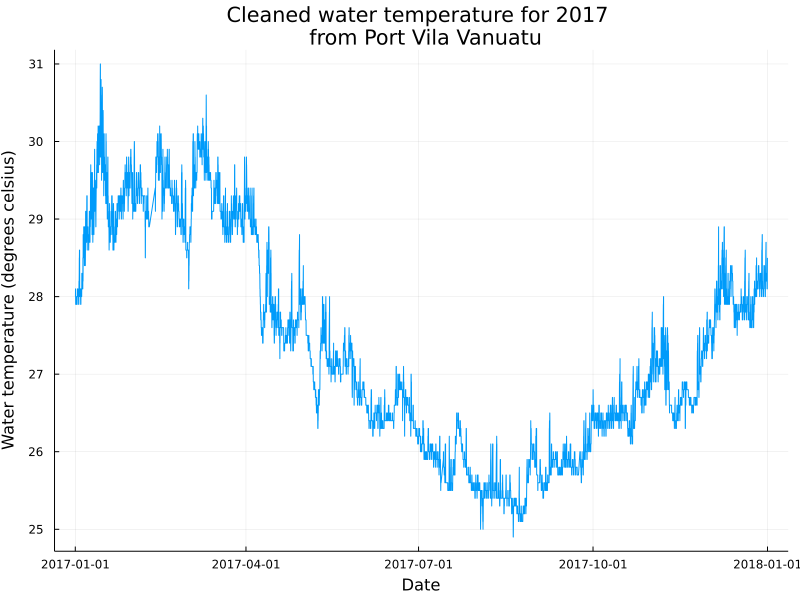

In [57]:
plot(w_temp[:, 1], w_temp[:, 2], 
    xlabel = "Date",
    ylabel = "Water temperature (degrees celsius)",
    label = false, 
    title = "Cleaned water temperature for 2017 \n from Port Vila Vanuatu",
    size = (800, 600))

In [58]:
describe(w_temp)

2×7 DataFrame
 Row │ variable    mean    min                  median  max                  n ⋯
     │ Symbol      Union…  Any                  Union…  Any                  I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ datetime2           2017-01-01T00:00:00          2017-12-31T23:00:00    ⋯
   2 │ water_temp  27.334  24.9                 27.1    31.0
                                                               2 columns omitted

The mean water temperature and median are close (27.334 and 27.1 respectively) and the water is warmest in the summer months, drops through autumn and is lowest in winter.
These traits indicated the removing the error value of -9999 has sufficiently cleaned the data.

The anomaly is now calculated and added to the dataframe as it is from the anomaly that the single harmonics are calculated.

In [59]:
wtemp_anom = w_temp[:, 2] .- mean(w_temp[:, 2])
insertcols!(w_temp, :w_anom => wtemp_anom)
first(w_temp, 5)

5×3 DataFrame
 Row │ datetime2            water_temp  w_anom   
     │ DateTime             Float64     Float64  
─────┼───────────────────────────────────────────
   1 │ 2017-01-01T00:00:00        28.0  0.666032
   2 │ 2017-01-01T01:00:00        28.0  0.666032
   3 │ 2017-01-01T02:00:00        28.0  0.666032
   4 │ 2017-01-01T03:00:00        28.1  0.766032
   5 │ 2017-01-01T04:00:00        28.1  0.766032

Now we look to fit discrete harmonics to the temperature anomaly data.
The harmonics are fitted using the `fourier_coeffs` function.
We will fit harmonics for $k = 1, 2, 3, 4$.

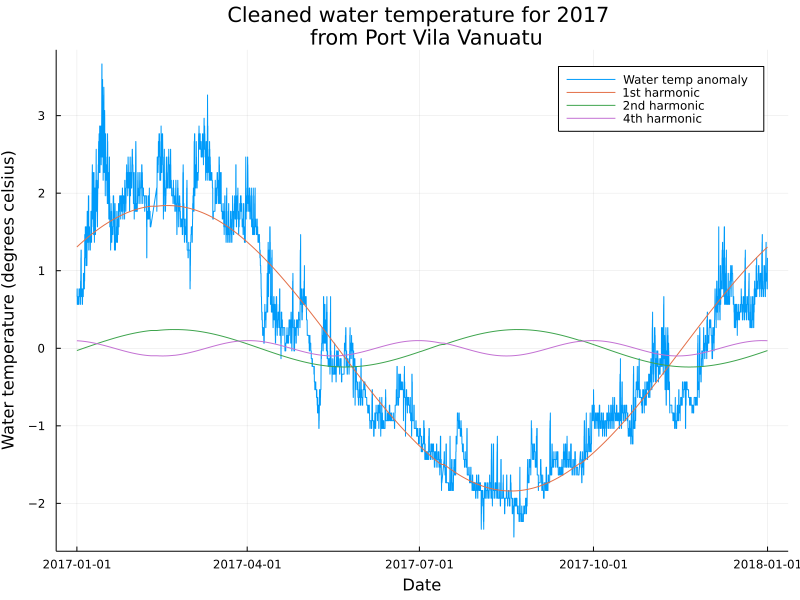

In [60]:
N = length(w_temp[:, 3])
i = range(1, N, step = 1)
k = [1, 2, 4]

# First harmonic
w_coeffs = fourier_coeffs(w_temp[:, 3], k[1])
water_first_harmonic = w_coeffs[1] * cosfunc(i, k[1], N) + w_coeffs[2] * sinfunc(i, k[1], N)
# Second harmonic 
w_coeffs = fourier_coeffs(w_temp[:, 3], k[2])
water_second_harmonic = w_coeffs[1] * cosfunc(i, k[2], N) + w_coeffs[2] * sinfunc(i, k[2], N)
# Fourth harmonic 
w_coeffs = fourier_coeffs(w_temp[:, 3], k[3])
water_fourth_harmonic = w_coeffs[1] * cosfunc(i, k[3], N) + w_coeffs[2] * sinfunc(i, k[3], N)

plot(w_temp[:, 1], w_temp[:, 3], 
    xlabel = "Date",
    ylabel = "Water temperature (degrees celsius)",
    label = "Water temp anomaly", 
    title = "Cleaned water temperature for 2017 \n from Port Vila Vanuatu",
    size = (800, 600))
plot!(w_temp[:, 1], water_first_harmonic, label = "1st harmonic")
plot!(w_temp[:, 1], water_second_harmonic, label = "2nd harmonic")
plot!(w_temp[:, 1], water_fourth_harmonic, label = "4th harmonic")


As there is only one macro cycle in this data (the annual warming and cooling of water temperature) and we have the data for one year the first harmonic does the best job of fitting.

The fit of the of the fourth harmonic is able to capture some of the smaller variations of the macro cycle but (unsurprisingly) neither the the second or the fourth harmonic provide much of a fit as we only have the data for one year.

The seasonal cycle can now be removed by subtracting the first harmonic from the temperature anomaly data.

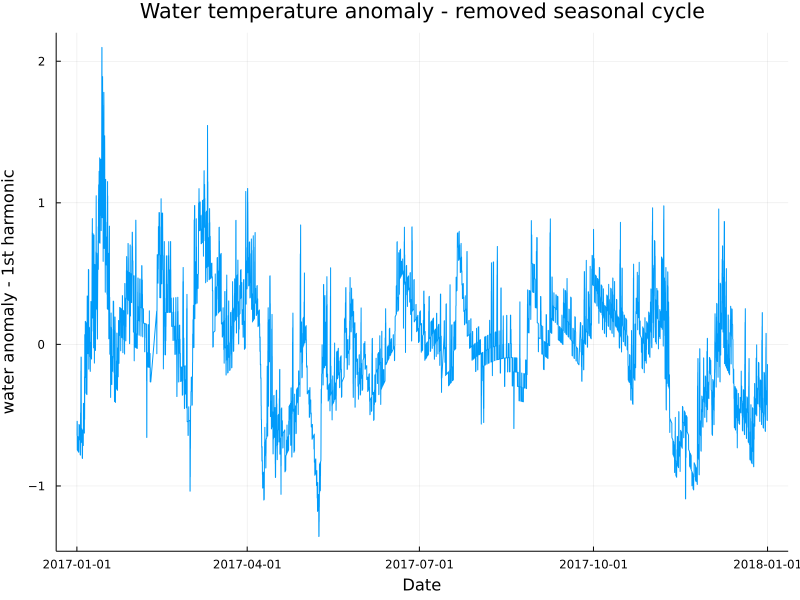

In [61]:
plot(w_temp[:, 1], w_temp[:, 3] .- water_first_harmonic, 
    xlabel = "Date", 
    ylabel = "water anomaly - 1st harmonic", 
    title = "Water temperature anomaly - removed seasonal cycle",
    label = false,
    size = (800, 600))

## Air temperature
Again remove the data entries corresponding to -9999.0 which are errors.

In [62]:
describe(a_temp)

2×7 DataFrame
 Row │ variable   mean      min                  median  max                   ⋯
     │ Symbol     Union…    Any                  Union…  Any                   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ datetime2            2017-01-01T00:00:00          2017-12-31T23:00:00   ⋯
   2 │ air_temp   -7.48828  -9999.0              25.6    32.7
                                                               2 columns omitted

In [63]:
find = findall(a_temp[:, 2] .== -9999.0)
delete!(a_temp, find);

Now we check to see if this has cleaned things up.

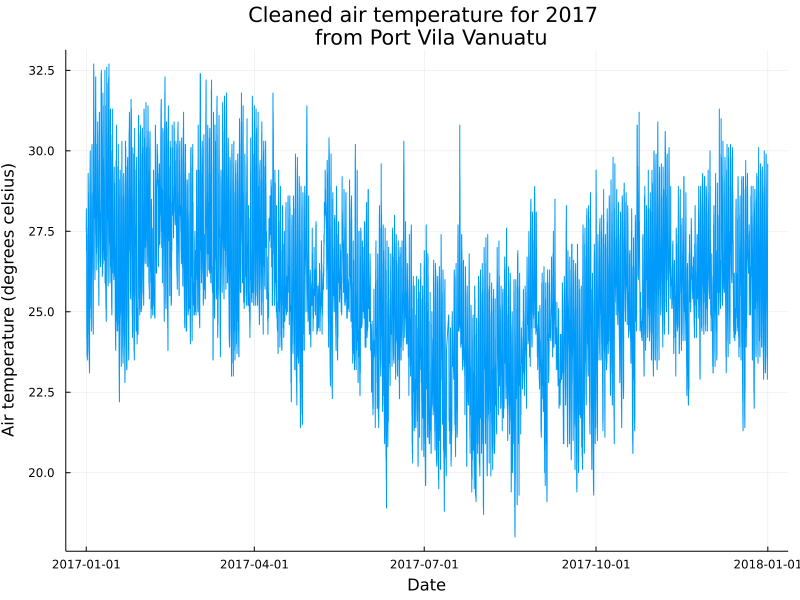

In [64]:
plot(a_temp[:, 1], a_temp[:, 2], 
    xlabel = "Date",
    ylabel = "Air temperature (degrees celsius)",
    label = false, 
    title = "Cleaned air temperature for 2017 \n from Port Vila Vanuatu",
    size = (800, 600))

In [65]:
describe(a_temp)

2×7 DataFrame
 Row │ variable   mean     min                  median  max                  n ⋯
     │ Symbol     Union…   Any                  Union…  Any                  I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ datetime2           2017-01-01T00:00:00          2017-12-31T23:00:00    ⋯
   2 │ air_temp   25.6985  18.0                 25.6    32.7
                                                               2 columns omitted

The mean and median are now much closer (almost the same) and the air temperature follows the annual cycle of warmer in summer and cooler in winter.
Again this indicates that removing the error value of -9999 has sufficiently cleaned the data.

Harmonics can now be fitted to the air temperature anomaly.
As this is also an annual shift from warmer to cooler, and we have one years worth of data, we expect that the first harmonic will capture this annual cycle (similarly to the water temperature anomaly).

In [66]:
atemp_anom = a_temp[:, 2] .- mean(a_temp[:, 2])
insertcols!(a_temp, :a_anom => atemp_anom)
first(a_temp, 5)

5×3 DataFrame
 Row │ datetime2            air_temp  a_anom  
     │ DateTime             Float64   Float64 
─────┼────────────────────────────────────────
   1 │ 2017-01-01T00:00:00      27.5  1.80149
   2 │ 2017-01-01T01:00:00      28.0  2.30149
   3 │ 2017-01-01T02:00:00      28.2  2.50149
   4 │ 2017-01-01T03:00:00      27.0  1.30149
   5 │ 2017-01-01T04:00:00      26.9  1.20149

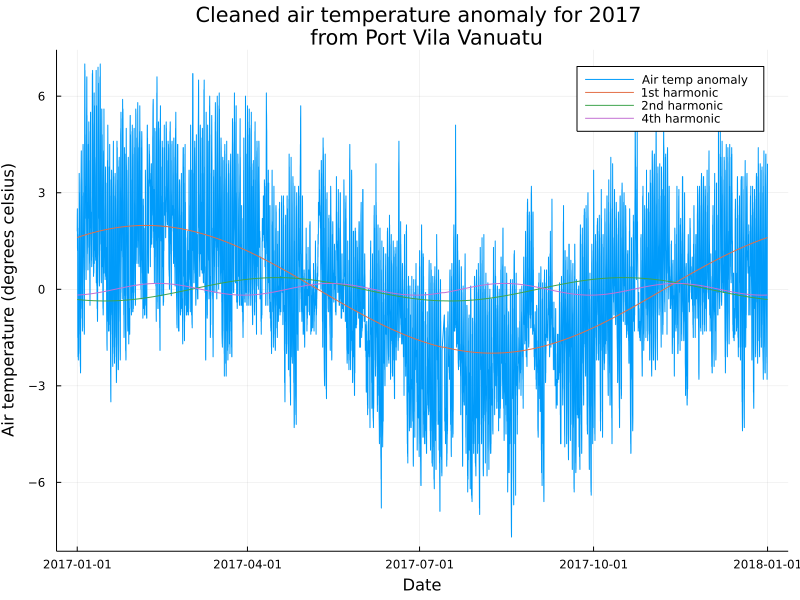

In [67]:
N = length(a_temp[:, 3])
i = range(1, N, step = 1)
k = [1, 2, 4, 365]

# First harmonic
a_coeffs = fourier_coeffs(a_temp[:, 3], k[1])
air_first_harmonic = a_coeffs[1] * cosfunc(i, k[1], N) + a_coeffs[2] * sinfunc(i, k[1], N)
# Second harmonic 
a_coeffs = fourier_coeffs(a_temp[:, 3], k[2])
air_second_harmonic = a_coeffs[1] * cosfunc(i, k[2], N) + a_coeffs[2] * sinfunc(i, k[2], N)
# Fourth harmonic 
a_coeffs = fourier_coeffs(a_temp[:, 3], k[3])
air_fourth_harmonic = a_coeffs[1] * cosfunc(i, k[3], N) + a_coeffs[2] * sinfunc(i, k[3], N)
# 365th harmonic corresponding to daily cycle, this is not plotted but explained in the appendix
#a_coeffs = fourier_coeffs(a_temp[:, 3], k[4])
#air_daily_harmonic = a_coeffs[1] * cosfunc(i, k[4], N) + a_coeffs[2] * sinfunc(i, k[4], N)

plot(a_temp[:, 1], atemp_anom, 
    xlabel = "Date",
    ylabel = "Air temperature (degrees celsius)",
    label = "Air temp anomaly", 
    title = "Cleaned air temperature anomaly for 2017 \n from Port Vila Vanuatu",
    size = (800, 600))
plot!(a_temp[:, 1], air_first_harmonic, label = "1st harmonic")
plot!(a_temp[:, 1], air_second_harmonic, label = "2nd harmonic")
plot!(a_temp[:, 1], air_fourth_harmonic, label = "4th harmonic")
#plot!(a_temp[:, 1], air_daily_harmonic, label = "365th harmonic")

As with the water temperature anomaly we have one year of data and the cycle is annual hence the 1st harmonic captures this cycle
The second and fourth harmonic reveal very little here.

Using the first harmonic the seasonal variation can be removed as was done for the water temperature anomaly.

# Sea level
Again there is data entered as -9999.0 that needs to be removed.
Once again removing these error values sufficiently cleans the data.

In [68]:
find = findall(sea_lvl[:, 2] .== -9999.0)
delete!(sea_lvl, find);

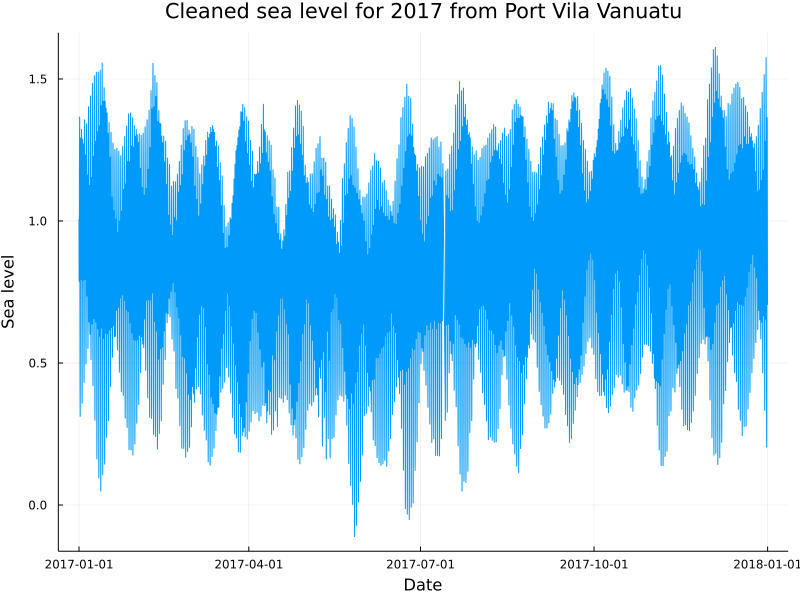

In [69]:
sea_lvl_plot = plot(sea_lvl[:, 1], sea_lvl[:, 2],
                    xlabel = "Date",
                    ylabel = "Sea level",
                    label = false, 
                    title = "Cleaned sea level for 2017 from Port Vila Vanuatu",
                    size = (800, 600))

In [70]:
describe(sea_lvl)

2×7 DataFrame
 Row │ variable   mean      min                  median  max                   ⋯
     │ Symbol     Union…    Any                  Union…  Any                   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ datetime2            2017-01-01T00:00:00          2017-12-31T23:00:00   ⋯
   2 │ sea_level  0.851854  -0.111               0.861   1.611
                                                               2 columns omitted

## Periodogram

We now fit a periodogram to the sea level data.
This will provide information about which frequencies contain the most power.
Selecting several of the frequencies that contain the most power and creating a superposition of harmonics using these frequencies will then give a more detailed data reconstruction than fitting single harmonics as we have done above.

### Fourier coefficients

Compute the Fourier coefficients using the real fast Fourier transfrom `rfft` from `FFTW.jl`.

In [71]:
sealvl_coeffs = (2 / N) .* rfft(sea_lvl[:, 2], 1)
Ck = abs.(sealvl_coeffs);

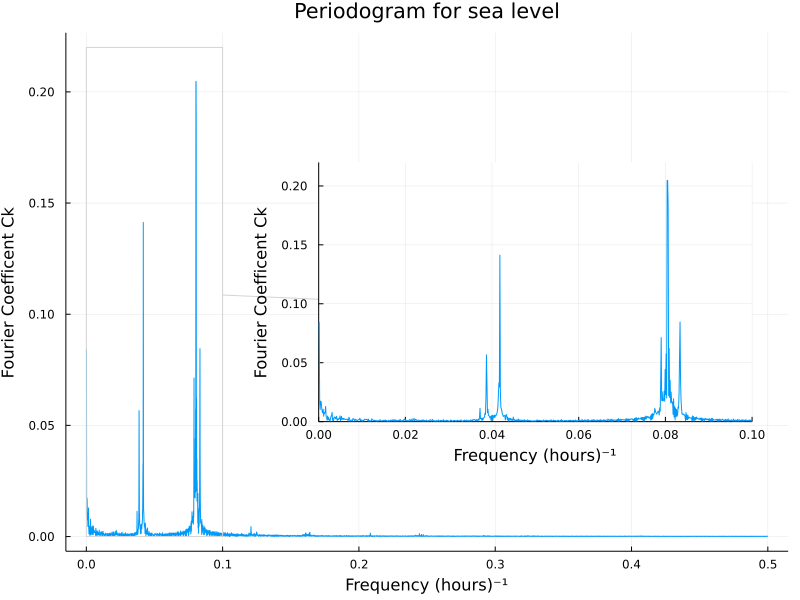

In [72]:
sealvl_coeffs = (2 / N) .* rfft(sea_lvl[:, 2], 1)
Ck = abs.(sealvl_coeffs) # Fourier coefficients

N = length(sea_lvl[:, 1]) #total number of hourly observations
fk = (1:round(Int64, N / 2) - 1) ./ N #frequencies

plot(fk, Ck[2:round(Int64, N / 2) ], # julia indexes from 1 so we only consider ffrom the second entry which is 2, rather than 1 in python.
    xlabel = "Frequency (hours)⁻¹",
    ylabel = "Fourier Coefficent Ck",
    title = "Periodogram for sea level",
    label = false,
    size = (800, 600))
lens!([0, 0.1], [0.0, 0.22], inset = (1, bbox(0.35, 0.25, 0.6, 0.5)), xlabel = "Frequency (hours)⁻¹", ylabel = "Fourier Coefficent Ck")

From the periodogram we see that frequencies with the most power occur very close to the beginning, just after $f_{k} = 0.04$ and just after $f_{k} = 0.08$.
We can locate the highest frequency using `findmax`,

In [73]:
fk_max = findmax(Ck[2:round(Int64, N / 2) ])

(0.204753266834779, 703)

This occurs at index 703 so the associated frequency and period is

In [74]:
println("Highest frequency "*string(fk[703]))
period = 1/fk[703]
println("Corresponding period is "*string(period))

Highest frequency 0.08051769556751803
Corresponding period is 12.419630156472262


So the period of 12.42 hours has the most power in this time series.
This aligns well with the changing of high to low tide that occurs approximately every 12.5 hours and is represented in the plot of one day of sea level data directly below.

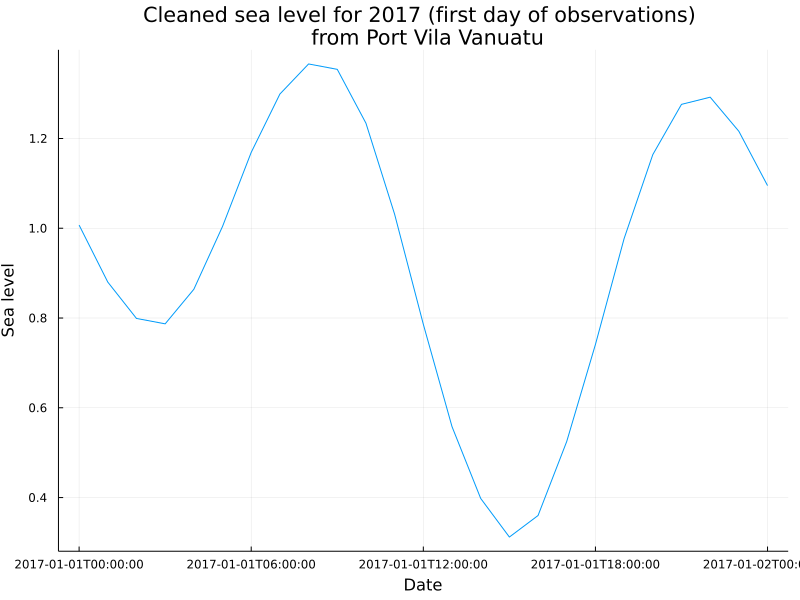

In [75]:
find_day = findfirst(sea_lvl[:, 1] .== DateTime(2017, 1, 2, 00, 00, 00))
plot(sea_lvl[1:find_day, 1], sea_lvl[1:find_day, 2],
    xlabel = "Date",
    ylabel = "Sea level",
    label = false, 
    title = "Cleaned sea level for 2017 (first day of observations) \n from Port Vila Vanuatu",
    size = (800, 600))

By sorting the frequency from highest to lowest we can look to find the other peak in power around $f_{k} = 0.04$.

In [76]:
sorted_Ck = sort(Ck, rev = true)
second_peak = sorted_Ck[5]
third_peak = sorted_Ck[7]

find_second_peak = findall(Ck .== second_peak)[1]
find_third_peak = findall(Ck .== third_peak)[1]
println("Second frequency "*string(fk[find_second_peak]))
period2 = 1/fk[find_second_peak]
println("Corresponding period "*string(period2))

Second frequency 0.041919596838850076
Corresponding period 23.8551912568306


The period with the next highest power is approximately 24 hours.
This is part of the diurnal cycle of the tides so again the amount of power it has is not surprising.

Now we take the first ten frequencies and recreate the time series using a superposition of harmonics.

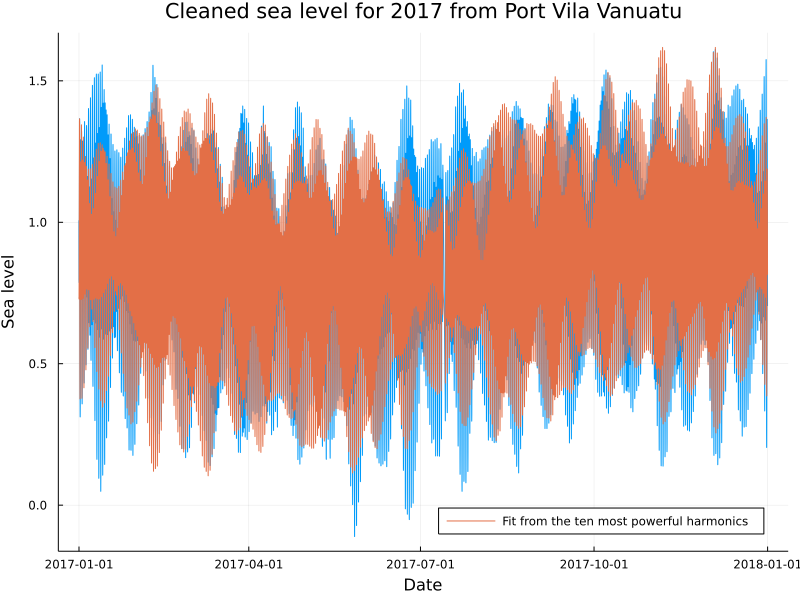

In [77]:
k_sea_lvl = 1:length(Ck[2:end])
p = sortperm(Ck[2:end], rev = true)
k_sea_lvl = k_sea_lvl[p]
N = length(sea_lvl[:, 2])
i = range(1, N, step = 1)
fit = zeros(N)

for j in 1:10
    
    s_coeffs = fourier_coeffs(sea_lvl[:, 2], k_sea_lvl[j])
    fit += s_coeffs[1] * cosfunc(i, k_sea_lvl[j], N) + s_coeffs[2] * sinfunc(i, k_sea_lvl[j], N)

end

plot!(sea_lvl_plot, sea_lvl[:, 1], fit .+ mean(sea_lvl[:, 2]), label = "Fit from the ten most powerful harmonics" ,legend = :bottomright, size = (800, 600))

The fit from the superposition captures much of the behaviour of the time series well.
Using a selection of the most powerful harmonics does provide a good way to reconstruct the data.

## Aliasing errors

The data is recorded hourly for a year.
With such frequent observations taken there does not seem to be an indication of aliasing errors as the physical processes that the sea level follow vary slower than the Nyquist frequency.
Several of these physical processes have been captured above from the harmonics with the highest power.

# References

[1]
Wilks, Daniel S. *Statistical methods in the atmospheric sciences 4th edition*

# Appendix

The following corrections were made based on the peer reviews I received:

* typographical errors - e.g forgot new line so heading was not rendered correctly

* spelling errors as kindly listed by one of the reviewers!

* I incorrectly labelled the diurnal cycle as a side effect of the 12 hour cycle. This has now been corrected.

The following suggestions I was either not exactly sure what was meant or did not implement them for reasons explained:

* I am not sure what index issue is being referred to by "I think there is an index issue in your A_k and B_k: it should be y_i." Julia indexes from one so maybe this is a misunderstanding as I think the way it is currently coded does do what is suggested here.

* I tried fitting a daily harmonic to the air temperature (it is left in the code but commented out) but it did not reveal anything on the particular plot that I made. Most likely I would have to adjust other things to make it look correct. It is unsurprising there is a strong diurnal pattern here though with air cooling at night and warming during the day.

* Instead of fitting monthly influences of neap and spring tides I have added a fit using multiple harmonics to the sea level data.

From carrying out my own peer reviews I:

* added a reconstruction of the sea level using a superposition of harmonics based on those with the most power from the periodogram.
